In [1]:
import qiskit_superstaq
import supermarq
# useful additional packages 
import numpy as np
import matplotlib.pyplot as plt

# importing Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile
from qiskit.providers.models import BackendConfiguration, BackendProperties

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.fake_provider import GenericBackendV2, Fake5QV1

C:\Users\User\AppData\Local\Temp\ipykernel_7256\3012424511.py:13: DeprecationWarning: qiskit.providers.models is deprecated since Qiskit 1.2 and will be removed in Qiskit 2.0. With the removal of Qobj, there is no need for these schema-conformant objects. If you still need to use them, it could be because you are using a BackendV1, which is also deprecated in favor of BackendV2.
  from qiskit.providers.models import BackendConfiguration, BackendProperties


In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.converters import circuit_to_instruction
 
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
circ = QuantumCircuit(q, c)
circ.h(q[0])
circ.cx(q[0], q[1])
circ.measure(q[0], c[0])
circ.rz(0.5, q[1]).c_if(c, 2)
circuit_to_instruction(circ)

Instruction(name='circuit-166', num_qubits=3, num_clbits=3, params=[])

We first set the length of the $n$-bit string. 

In [3]:
n = 10 # the length of the first register for querying the oracle 

We then use Qiskit to program the algorithm.

In [4]:
# Choose a type of oracle at random. With probability half it is constant, 
# and with the same probability it is balanced
oracleType, oracleValue = np.random.randint(2), np.random.randint(2)

if oracleType == 0:
    print("The oracle returns a constant value ", oracleValue)
else:
    print("The oracle returns a balanced function")
    a = np.random.randint(1,2**n) # this is a hidden parameter for balanced oracle. 

# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1) #all qubits are initialized to zero
# for recording the measurement on the first register
cr = ClassicalRegister(n, name='res')

circuitName = "DeutschJozsa"
djCircuit = QuantumCircuit(qr, cr)

# Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    djCircuit.h(qr[i])

# Flip the second register and apply the Hadamard gate.
djCircuit.x(qr[n])
djCircuit.h(qr[n])
    
# Apply barrier to mark the beginning of the oracle
djCircuit.barrier()

if oracleType == 0:#If the oracleType is "0", the oracle returns oracleValue for all input. 
    if oracleValue == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.id(qr[n])
else: # Otherwise, it returns the inner product of the input with a (non-zero bitstring) 
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
        
# Apply barrier to mark the end of the oracle
djCircuit.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])
    
# Measurement
djCircuit.barrier()
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

The oracle returns a balanced function


## Experiment with Simulators

We can run the above circuit on the simulator. 

First, we draw the circuit.

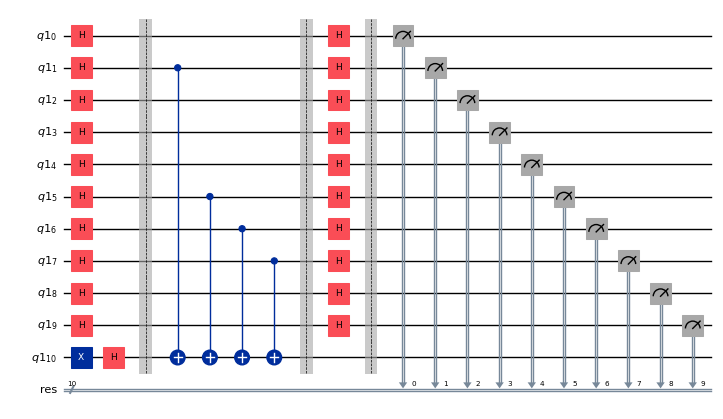

In [5]:
#draw the circuit
djCircuit.draw(output='mpl',scale=0.5)

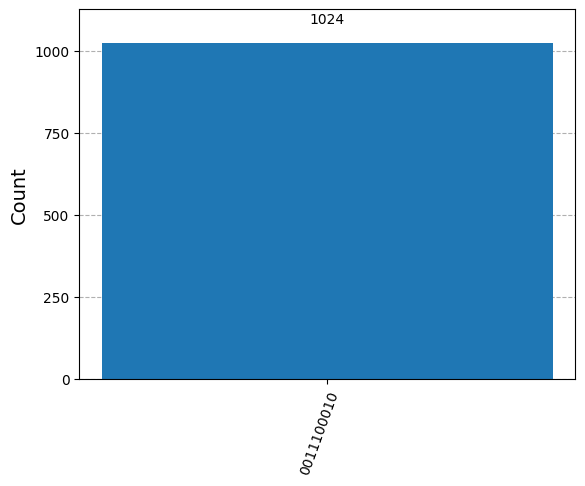

In [6]:
sampler = StatevectorSampler()
job = sampler.run([djCircuit])
results = job.result()
plot_histogram(results[0].data.res.get_counts())

## Get Backend Data

In [49]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Cloud account.
QiskitRuntimeService.save_account(channel="ibm_cloud", token="4f9908f6c0fad0af5071fbd47a6dc32c5332175de571f89e778689f3b362892ee273ecdbc984e25ce0fc047c3cfd4db66e5bf4764a1035773d305557a4eb6836", instance="ibm-q/open/main",overwrite=True)

# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="4f9908f6c0fad0af5071fbd47a6dc32c5332175de571f89e778689f3b362892ee273ecdbc984e25ce0fc047c3cfd4db66e5bf4764a1035773d305557a4eb6836",overwrite=True)

In [ ]:
# Initialize your account
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
 
service.backends()

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

## Transpile and noise

In [7]:
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.providers.fake_provider import Fake20QV1
 
# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
# Run the sampler job locally using FakeManilaV2
Fake20QV1 = Fake20QV1()
pm = generate_preset_pass_manager(backend=Fake20QV1, optimization_level=1)
isa_qc = pm.run(djCircuit)
 
# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}
sampler = Sampler(mode=Fake20QV1, options=options)
 
result = sampler.run([isa_qc]).result()

C:\Users\User\AppData\Local\Temp\ipykernel_7256\1423447870.py:14: DeprecationWarning: The `generate_preset_pass_manager` function will stop supporting inputs of type `BackendV1` ( fake_20q_v1 ) in the `backend` parameter in a future release no earlier than 2.0. `BackendV1` is deprecated and implementations should move to `BackendV2`.
  pm = generate_preset_pass_manager(backend=Fake20QV1, optimization_level=1)


In [8]:
from qiskit.providers.fake_provider import Fake20QV1

C:\Users\User\AppData\Local\Temp\ipykernel_7256\1376433729.py:3: DeprecationWarning:  from_backend using V1 based backend is deprecated as of Aer 0.15 and will be removed no sooner than 3 months from that release date. Please use backends based on V2.
  sim_vigo = AerSimulator.from_backend(backend)


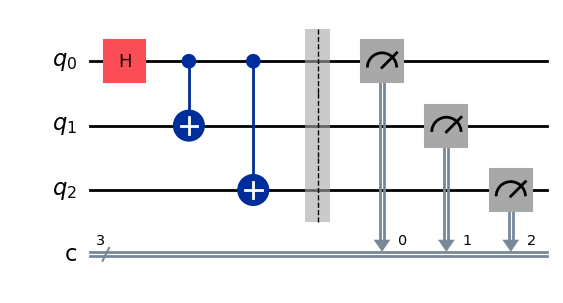

In [10]:
from qiskit_aer import AerSimulator
backend = Fake20QV1()
sim_vigo = AerSimulator.from_backend(backend)
ghz = QuantumCircuit(3, 3)
ghz.h(0)
ghz.cx(0,range(1,3))
ghz.barrier()
ghz.measure(range(3), range(3))
ghz.draw(output='mpl')

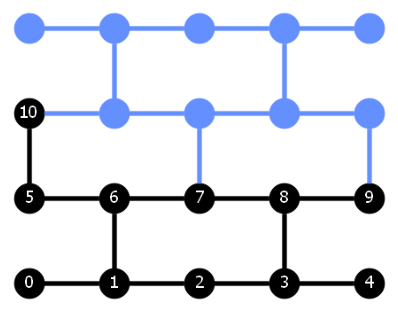

In [14]:
new_circ_lv0 = transpile(djCircuit, backend=sim_vigo, optimization_level=0)
plot_circuit_layout(new_circ_lv0, backend)

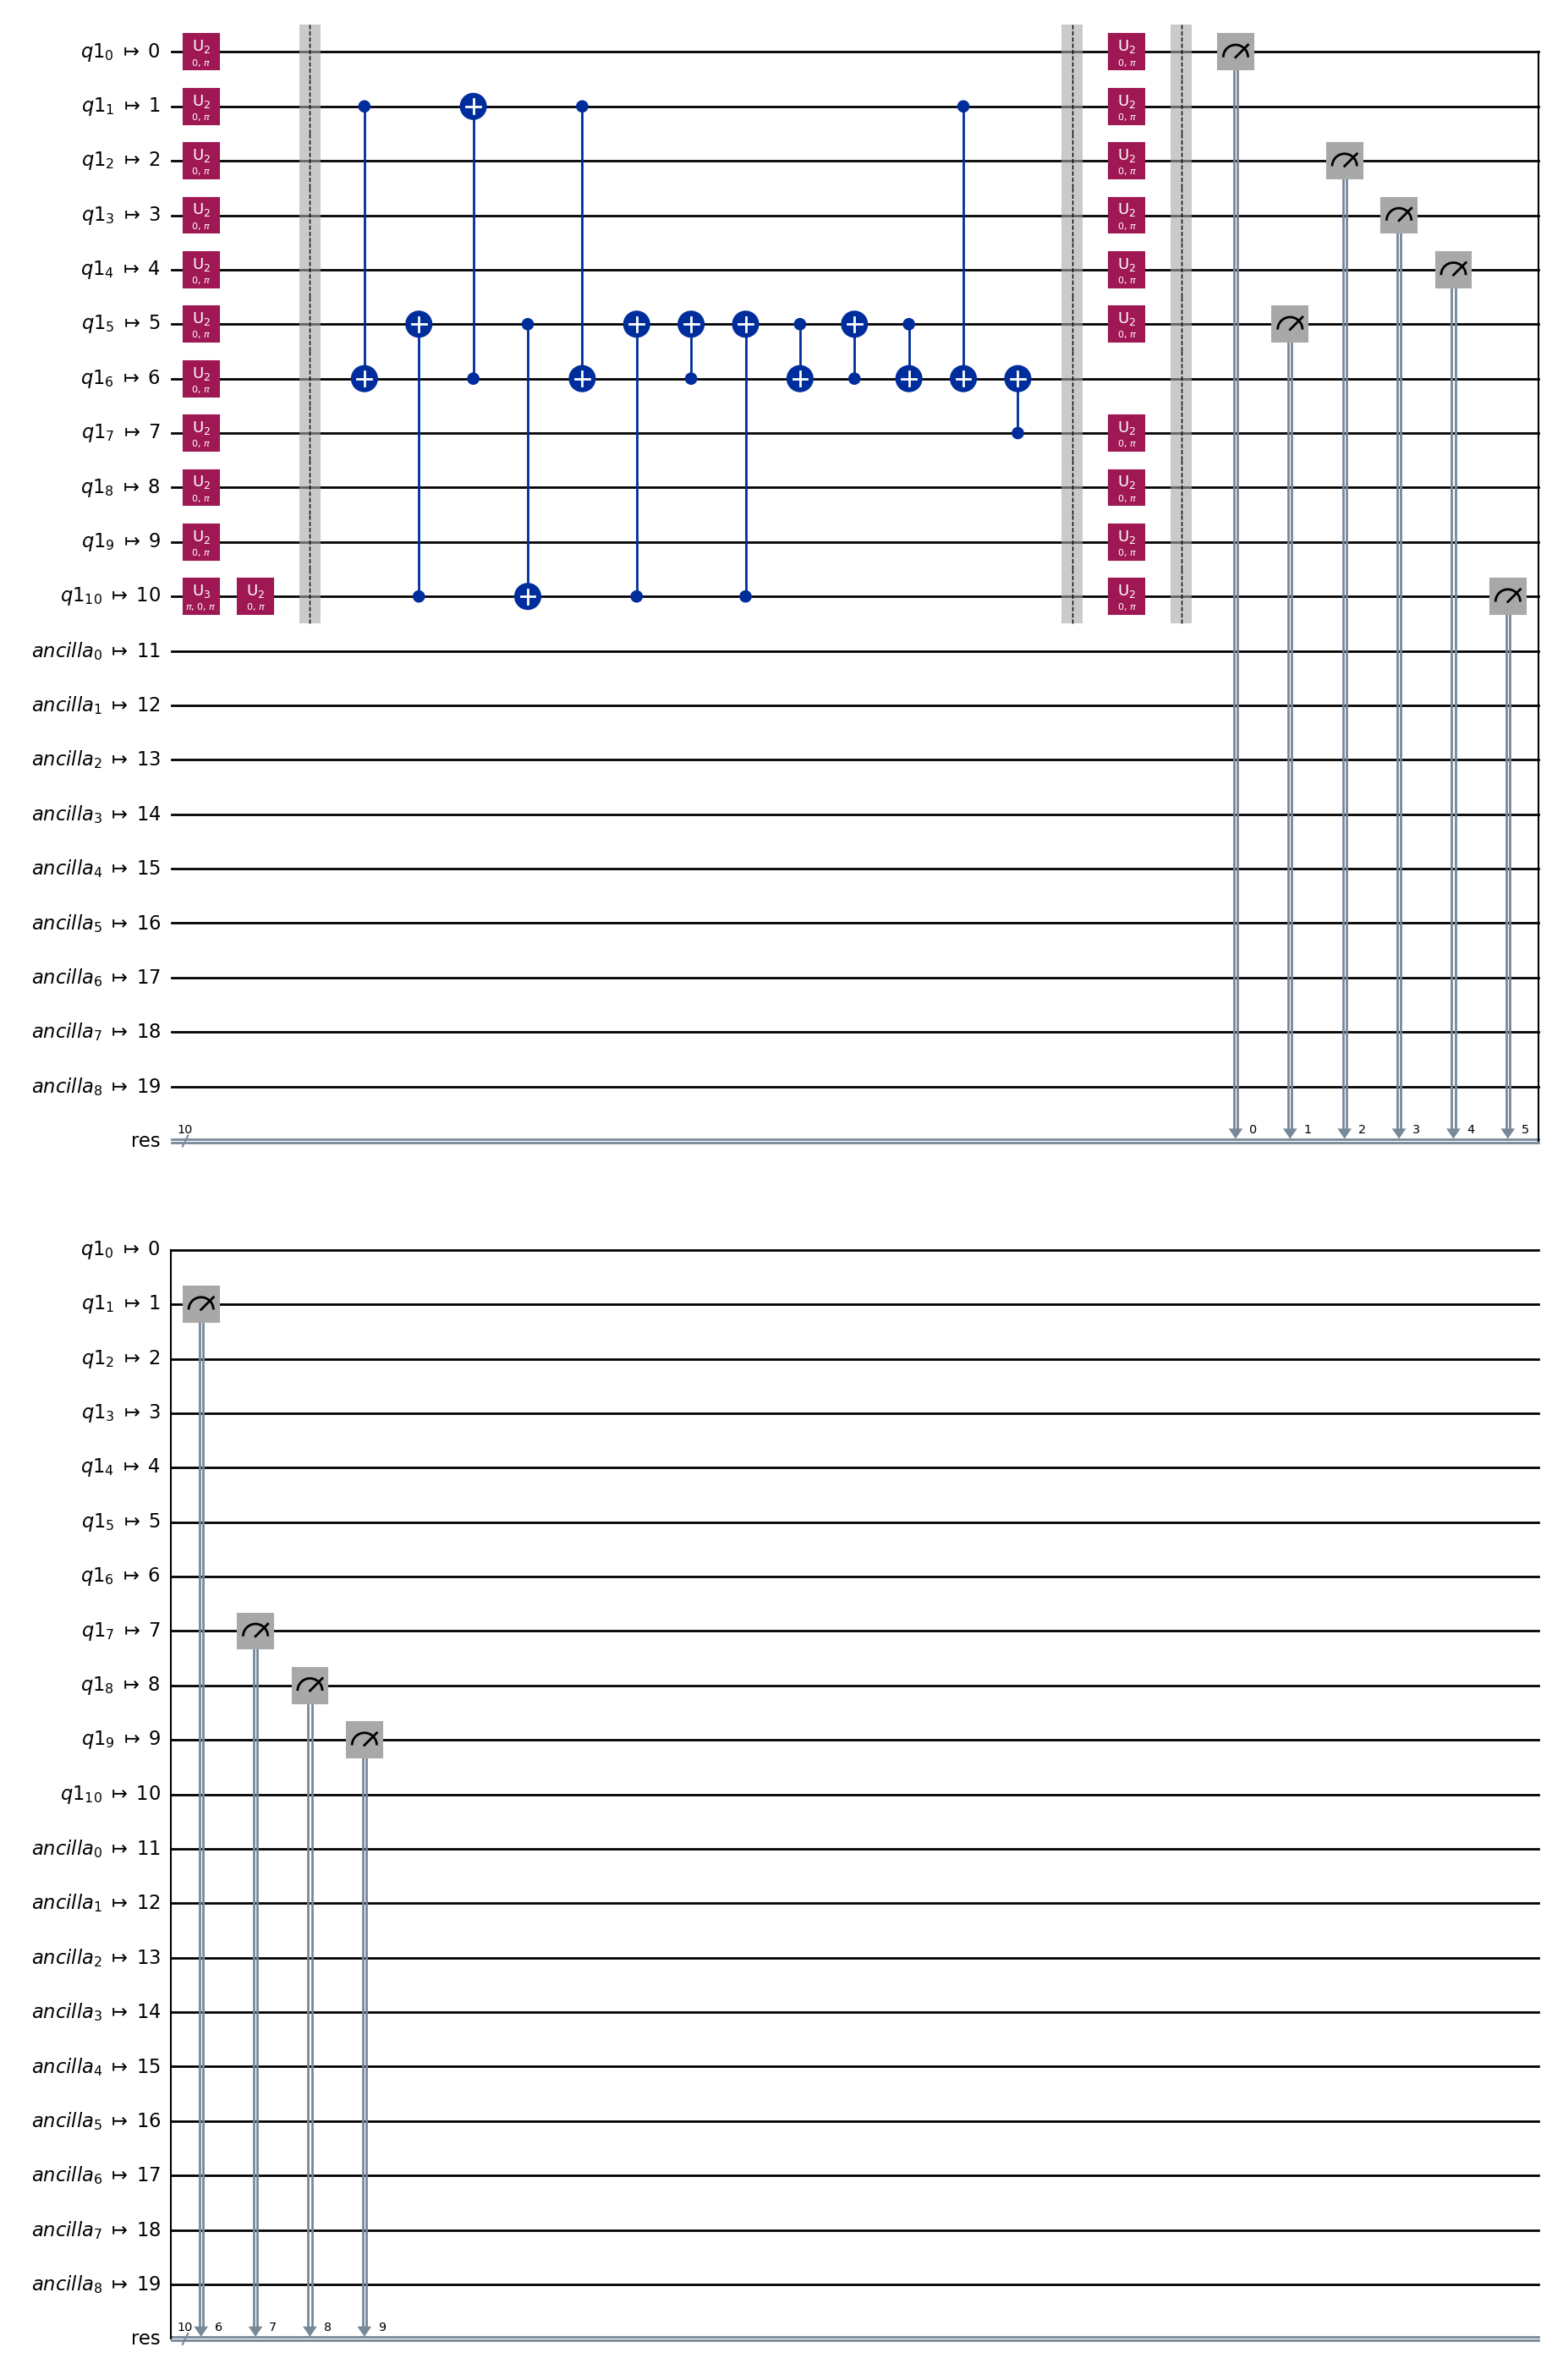

In [15]:
new_circ_lv0.draw(output='mpl')

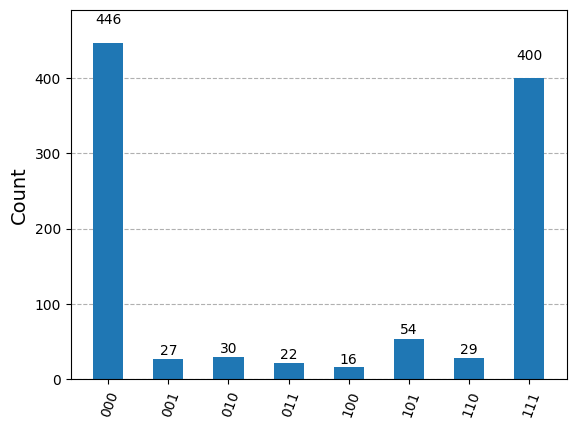

In [13]:
# Run the transpiled circuit using the simulated backend
job = sim_vigo.run(new_circ_lv0)
counts = job.result().get_counts()
plot_histogram(counts)

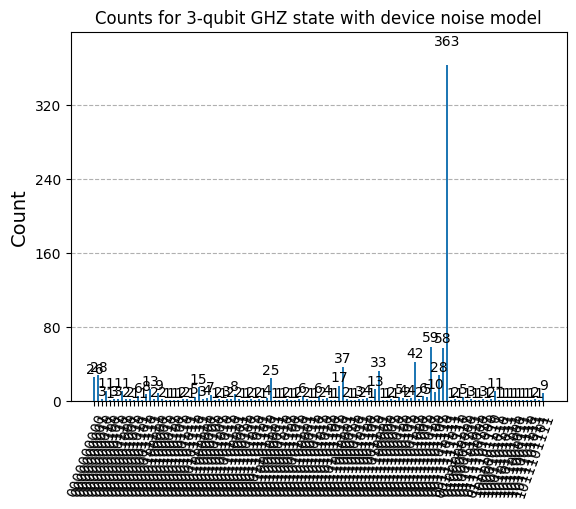

In [16]:
# Execute noisy simulation and get counts
result_noise = backend.run(new_circ_lv0).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")

In [29]:
# Execute noisy simulation and get counts
result_noise = backend.run(new_circ_lv0).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")

AttributeError: 'NoiseModel' object has no attribute 'run'

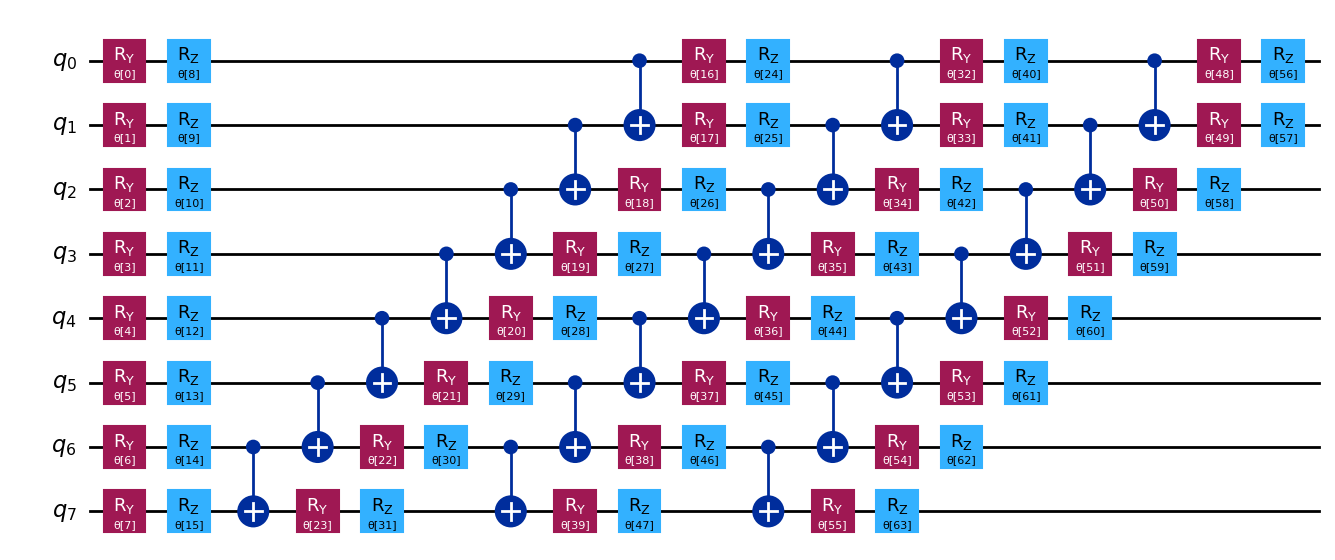

In [17]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 8
circuit = EfficientSU2(n_qubits)
circuit.decompose().draw("mpl")

In [24]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
 
observable = SparsePauliOp("Z" * 11)
params = [0.1] * djCircuit.num_parameters
 
exact_estimator = Estimator()
# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(0, AerSimulator())
isa_circuit = pass_manager.run(djCircuit)
pub = (isa_circuit, observable, params)
job = exact_estimator.run([pub])
result = job.result()
pub_result = result[0]
exact_value = float(pub_result.data.evs)
exact_value

0.0

In [25]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
 
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)
 
noisy_estimator = Estimator(options=dict(backend_options=dict(noise_model=noise_model)))
job = noisy_estimator.run([pub])
result = job.result()
pub_result = result[0]
noisy_value = float(pub_result.data.evs)
noisy_value

0.0

In [26]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
 
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)
 
noisy_estimator = Estimator(options=dict(backend_options=dict(noise_model=noise_model)))
job = noisy_estimator.run([pub])
result = job.result()
pub_result = result[0]
noisy_value = float(pub_result.data.evs)
noisy_value

0.0

## Noise model

In [21]:
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [23]:
noise_model = NoiseModel.from_backend(Fake20QV1())

C:\Users\User\AppData\Local\Temp\ipykernel_6808\4133447489.py:1: DeprecationWarning:  from_backend using V1 based backend is deprecated as of Aer 0.15 and will be removed no sooner than 3 months from that release date. Please use backends based on V2.
  noise_model = NoiseModel.from_backend(Fake20QV1())


In [33]:
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


In [28]:
# Convert to Kraus operator
bit_flip_kraus = SuperOp(new_circ_lv0)
print(bit_flip_kraus)

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

## Benchmarking


In [ ]:
ghz_circuit = new_circ_lv0
ghz_features = [
    supermarq.converters.compute_communication_with_qiskit(ghz_circuit),
    supermarq.converters.compute_depth_with_qiskit(ghz_circuit),
    supermarq.converters.compute_entanglement_with_qiskit(ghz_circuit),
    supermarq.converters.compute_liveness_with_qiskit(ghz_circuit),
    supermarq.converters.compute_measurement_with_qiskit(ghz_circuit),
    supermarq.converters.compute_parallelism_with_qiskit(ghz_circuit),
]
print(ghz_features)

In [ ]:
supermarq.plotting.plot_benchmark(
    title="A single GHZ benchmark",
    labels=["ghz_circuit"],
    features=[ghz_features],
    spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],
)

In [ ]:
!pip freeze